#Setup
https://www.kaggle.com/datasets/atulanandjha/lfwpeople

## Install and Import Dependencies

In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available: 0


In [2]:
!pip install opencv-python matplotlib

In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### create folder structure

In [6]:
# setup paths
base_path = '/content/drive/MyDrive/SmartShield/SmartShield_data'
pos_path = os.path.join(base_path, 'positive')
neg_path = os.path.join(base_path, 'negative')
anc_path = os.path.join(base_path, 'anchor')

In [ ]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

In [7]:
%cd /content/drive/MyDrive/SmartShield/SmartShield_data

/content/drive/MyDrive/SmartShield/SmartShield_data


In [8]:
!ls

anchor	negative  positive  siamesemodel.h5  training_checkpoints


In [9]:
!tar -xf lfw-funneled.tgz

tar: lfw-funneled.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# move lfw images to following repository SmartShield_data/negative
for directory in os.listdir('lfw_funneled'):
    for file in os.listdir(os.path.join('lfw_funneled', directory)):
        EX_PATH = os.path.join('lfw_funneled', directory, file)
        NEW_PATH = os.path.join(neg_path, file)
        os.replace(EX_PATH, NEW_PATH)


## Positive and Anchor classes Collection

In [ ]:
# connection establishment to webcame
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  cv2.imshow('Image Collection', frame)
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

# Load and preprocess images


## Get image directories

In [9]:
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(400)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'/content/drive/MyDrive/SmartShield/SmartShield_data/anchor/3ba766a7-685a-11f0-84ef-745d2221ca39.jpg'


## Preprocessing

In [12]:
def preprocess(file_path):
    # Read image
    byte_img = tf.io.read_file(file_path)
    # Load image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105, 105))
    # Scale image to be between 0 and 1
    img = img / 255.0
    # Return image
    return img

In [13]:
img = preprocess('/content/drive/MyDrive/SmartShield/SmartShield_data/anchor/30c06aae-685a-11f0-bb30-745d2221ca39.jpg')

In [14]:
img.numpy().max()

np.float32(1.0)

In [15]:
img.numpy().min()

np.float32(0.0)

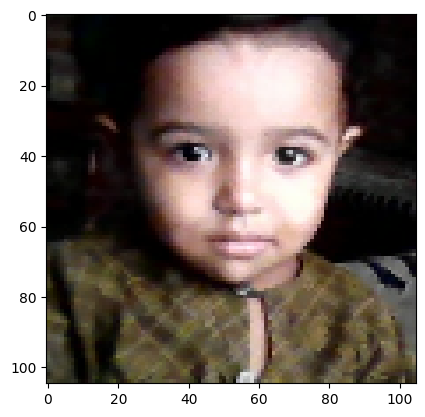

In [16]:
plt.imshow(img)

## Create labelled dataset

In [17]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()

In [20]:
example

(b'/content/drive/MyDrive/SmartShield/SmartShield_data/anchor/2c7aec7f-685a-11f0-bc8f-745d2221ca39.jpg',
 b'/content/drive/MyDrive/SmartShield/SmartShield_data/positive/4108b6af-685a-11f0-91fc-745d2221ca39.jpg',
 np.float32(1.0))

## Train and Test Partitioning

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
result = preprocess_twin(*example)

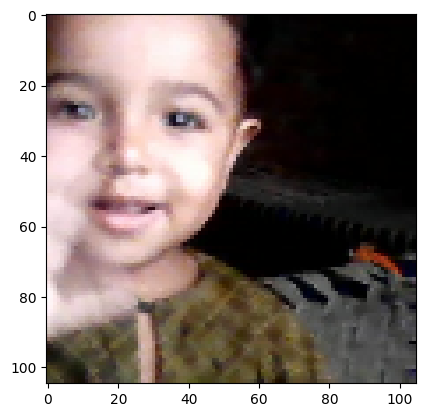

In [23]:
plt.imshow(result[0])

In [24]:
result[2]

np.float32(1.0)

### Dataloader pipeline

In [24]:
# building dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
samples = data.as_numpy_iterator()

In [ ]:
len(samples.next())

In [ ]:
samp = samples.next()

In [ ]:
# samp[0] -> anchor image
plt.imshow(samp[0])

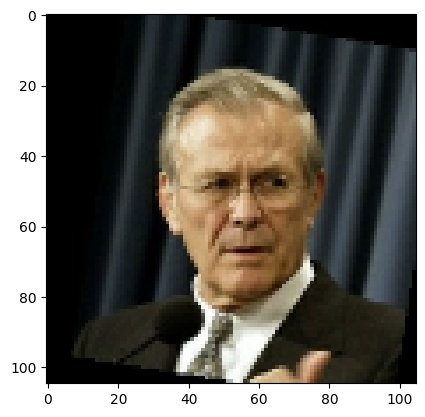

In [35]:
# samp[1] -> positive / negative image
plt.imshow(samp[1])

In [36]:
# samp[2] -> Label (0 for anchor and negative | 1 for anchor and positive)
samp[2]

np.float32(0.0)

In [26]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

#**Model Building**

### Build Embedding layer

In [28]:
inp = Input(shape=(105,105,3), name='input_image')

In [29]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [30]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [31]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [32]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [33]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [34]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    # dense or fully connected layer
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=inp, outputs=d1, name='embedding')

In [37]:
embedding = make_embedding()

In [38]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Build Distance Layer

In [39]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
l1 = L1Dist()

In [41]:
l1

<L1Dist name=l1_dist, built=False>

# Make Siamese Model

In [42]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [43]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [44]:
siamese_layer = L1Dist()

In [45]:
distances = siamese_layer(inp_embedding, val_embedding)

In [46]:
classifier = Dense(1, activation='sigmoid')(distances)

In [47]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def make_siamese_model():
    # Anchor image input
    input_image = Input(name='input_img', shape=(105,105,3))

    # Validation image
    validation_image = Input(name='validation_img', shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_model = make_siamese_model()

In [52]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

### Setup Loss and Optimizer

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### Establish **Checkpoints**

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Train Step Function

In [68]:
# test_batch = train_data.as_numpy_iterator()
# batch_1 = test_batch.next()
# X = batch_1[:2]
# y = batch_1[2]

In [ ]:
# y

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [56]:
# compiles function into a callable tensorflow graph
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## Build training loop

In [57]:
def train(data, EPOCHS):
    all_epoch_losses = []
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        # store batch loss for current epoch
        epoch_loss = []

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            # convert tensor to number
            epoch_loss.append(loss.numpy())
            progbar.update(idx+1)

        # Compute average loss for this epoch
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        print(f"Average Loss for Epoch {epoch}: {avg_loss:.4f}")

        # Add this epoch’s average loss to the list
        all_epoch_losses.append(avg_loss)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    return all_epoch_losses

## Train the model

In [71]:
EPOCHS = 50
losses = train(train_data, EPOCHS)


 Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step
Average Loss for Epoch 1: 0.3232

 Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step
Average Loss for Epoch 2: 0.0755

 Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step
Average Loss for Epoch 3: 0.0152

 Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Average Loss for Epoch 4: 0.0429

 Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Average Loss for Epoch 5: 0.0320

 Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step
Average Loss for Epoch 6: 0.0474

 Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step
Average Loss for Epoch 7: 0.0038

 Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Average Loss for Epoch 8: 0.0105

 Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Average Loss for Epoch 9: 0.0122

 Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step
Average Loss for Epoch 10: 0.0638

 Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Average Loss for Epoch 11: 0.0342

 Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━

### Plot the loss per epcoh

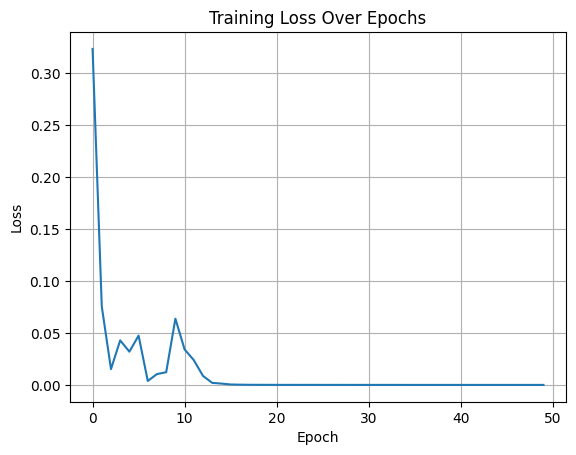

In [72]:
# Plot all losses
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

# Model Evaluation

In [58]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [75]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[9.9999964e-01],
       [1.0000000e+00],
       [7.2826737e-07],
       [1.5416914e-08],
       [3.1158559e-10],
       [7.9270372e-05],
       [1.0000000e+00],
       [3.0303091e-09],
       [2.4011543e-08],
       [4.8238931e-08],
       [1.0000000e+00],
       [2.3767545e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [76]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]

In [77]:
y_true

array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

### Calculation

In [81]:
# Creating a metric object
m = Recall()
# Calculating the recall value
m.update_state(y_true, y_hat)
# Return Recall Result
m.result().numpy()

np.float32(1.0)

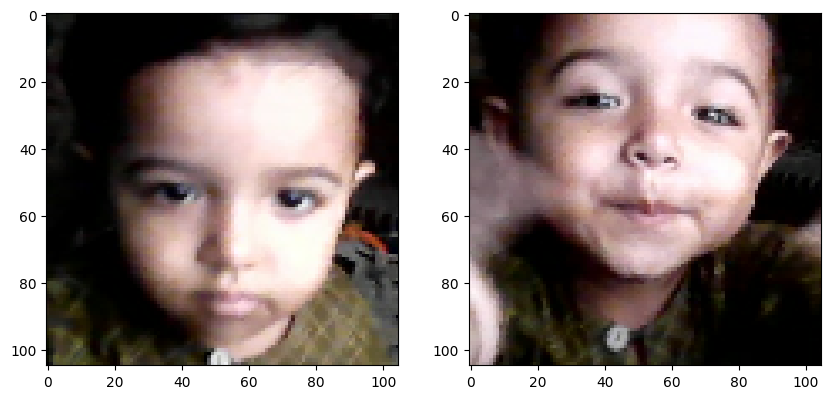

In [82]:
# Set plot size
plt.figure(figsize=(10,8))
# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])
# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
# Renders cleanly
plt.show()

# Save Model

In [83]:
siamese_model.save('siamesemodel.h5')
L1Dist

__main__.L1Dist

In [59]:
# Reload
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [85]:
# Make prediction with reload model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


array([[9.9999964e-01],
       [1.0000000e+00],
       [7.2826737e-07],
       [1.5416914e-08],
       [3.1158559e-10],
       [7.9270372e-05],
       [1.0000000e+00],
       [3.0303091e-09],
       [2.4011543e-08],
       [4.8238931e-08],
       [1.0000000e+00],
       [2.3767545e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [86]:
# Model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.export('siamesemodel')

Saved artifact at 'siamesemodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='input_img'), TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='validation_img')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137169617348816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617350352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617349776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617351120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617350544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617351888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617351312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617352656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137169617352080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13716

In [62]:
!zip -r siamesemodel.zip siamesemodel

  adding: siamesemodel/ (stored 0%)
  adding: siamesemodel/variables/ (stored 0%)
  adding: siamesemodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: siamesemodel/variables/variables.index (deflated 64%)
  adding: siamesemodel/assets/ (stored 0%)
  adding: siamesemodel/saved_model.pb (deflated 86%)
  adding: siamesemodel/fingerprint.pb (stored 0%)
